In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import empyrikos as eb
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, matthews_corrcoef

from scipy.stats import ttest_1samp
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from statsmodels.stats.multitest import multipletests
from matplotlib_venn import venn2
from scipy.stats import ttest_ind
import math
from scipy.stats import t

In [2]:
## bay across plates 
phase2_df=pd.read_csv('phase2_99_bay_std_across_slope(5.18).csv',low_memory=False)
cts_light = ['20h_HL', '20h_ML']
phase2_df['y2_slope_select'] = phase2_df.apply(
    lambda row: row['y2_slope'] if row['light_regime'] in cts_light else row['y2_slope_on'],
    axis=1
)


In [3]:
phase2_df = phase2_df[~phase2_df['plate'].astype(str).str.startswith('99')]

In [4]:
wt_df = phase2_df[phase2_df['mutant_ID'] == 'WT']
mutant_df = phase2_df[phase2_df['mutant_ID'] != 'WT']

## paired t test (mutant)

In [5]:
paired_delta_results = []

group_keys = ['mutant_ID', 'mutated_genes', 'light_regime']
grouped = mutant_df.groupby(group_keys)

for (mutant_id, gene, regime), group in grouped:
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    deltas = []
    for _, row in group.iterrows():
        plate = row['plate']
        mutant_val = row['y2_slope_select']

        wt_plate_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()

        if wt_plate_vals.empty:
            continue

        delta = mutant_val - wt_plate_vals.mean()
        deltas.append(delta)

    if len(deltas) < 2:
        continue

    deltas = np.array(deltas)
    delta_mean = deltas.mean()
    se_hat = deltas.std(ddof=1) / np.sqrt(len(deltas))  # standard error of the mean

    paired_delta_results.append({
        'mutant_ID': mutant_id,
        'mutated_genes': gene,
        'light_regime': regime,
        'n_replicates': len(deltas),
        'delta_mean': delta_mean,
        'se_hat': se_hat
    })

# Save for R use
paired_delta_df = pd.DataFrame(paired_delta_results)

In [6]:
# 1) Prepare inputs for EPB
paired_delta_df = pd.DataFrame(paired_delta_results).copy()
paired_delta_df["df"] = paired_delta_df["n_replicates"] - 1
paired_delta_df["se_hat_sq"] = (paired_delta_df["se_hat"] ** 2)

# guard against zero/NaN SEs
paired_delta_df.loc[~np.isfinite(paired_delta_df["se_hat_sq"]) | (paired_delta_df["se_hat_sq"] <= 0), "se_hat_sq"] = 1e-12
paired_delta_df.loc[paired_delta_df["df"] < 1, "df"] = 1  # should already be ≥1, but just in case

In [7]:
paired_delta_df

,mutant_ID,mutated_genes,light_regime,n_replicates,delta_mean,se_hat,df,se_hat_sq
0,LMJ.RY0402.038618,Cre17.g708800,10min-10min,2,-0.000797,0.000179,1,3.189016e-08
1,LMJ.RY0402.038618,Cre17.g708800,1min-1min,3,-0.001094,0.000131,2,1.708804e-08
2,LMJ.RY0402.038618,Cre17.g708800,1min-5min,3,0.000009,0.000203,2,4.102979e-08
3,LMJ.RY0402.038618,Cre17.g708800,20h_HL,2,-0.001467,0.000470,1,2.211135e-07
4,LMJ.RY0402.038618,Cre17.g708800,20h_ML,3,-0.000790,0.000512,2,2.618612e-07
...,...,...,...,...,...,...,...,...
8529,LMJ.RY0402.257268,"Cre03.g191250,Cre03.g191350",20h_HL,4,-0.001427,0.000602,3,3.618503e-07
8530,LMJ.RY0402.257268,"Cre03.g191250,Cre03.g191350",20h_ML,3,-0.001476,0.000128,2,1.647717e-08
8531,LMJ.RY0402.257268,"Cre03.g191250,Cre03.g191350",2h-2h,3,-0.000907,0.000239,2,5.711117e-08
8532,LMJ.RY0402.257268,"Cre03.g191250,Cre03.g191350",30s-30s,3,-0.001675,0.000058,2,3.398323e-09


In [8]:
from statsmodels.stats.multitest import multipletests
fits = {}
rows = []

for regime, g in paired_delta_df.groupby("light_regime"):
    r = eb.epb_ttest(
        beta_hat=g["delta_mean"].to_numpy(),
        se_hat_squared=g["se_hat_sq"].to_numpy(),
        df=g["df"].to_numpy(),
        alpha=0.05,
    )
    fits[regime] = r

    g = g.copy()
    two_sided_p = getattr(r, "pvalues", np.nan)

    # Convert to one-sided depending on direction of delta_mean
    one_sided_p = np.where(
        g["delta_mean"] < 0,  # test for positive effects
        two_sided_p / 2,
        1 - two_sided_p / 2
    )

    g["p_value"] = one_sided_p
    g["p_adj"] = multipletests(g["p_value"], method="fdr_bh")[1]
    rows.append(g)



epb_by_regime = pd.concat(rows, ignore_index=True)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython

 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   3.1347e-02  -2.9230e+02 | 2.43e+03  2.15e+02  1.68e+00 | 1.00e+00  1.00e+00  1.00e+00 |
    1  -1.1588e+00  -2.9752e+02 | 2.31e+03  2.18e+02  1.70e+00 | 9.37e-01  1.01e+00  9.50e-01 | 5.9e-12  9.1e-02  co-a  5.00e-02
    2  -2.5918e+00  -3.0060e+02 | 2.19e+03  2.20e+02  1.71e+00 | 8.85e-01  1.02e+00  9.03e-01 | 1.9e-12  1.4e-01  co-a  5.00e-02
    3  -6.0926e+00  -3.0490e+02 | 1.97e+03  2.20e+02  1.72e+00 | 7.94e-01  1.02e+00  8.12e-01 | 1.8e-12  4.2e-01  co-a  1.00e-01
    4  -1.0511e+01  -3.1030e+02 | 1.78e+03  2.21e+02  1.72e+00 | 7.12e-01  1.03e+00  7.31e-01 | 3.6e-12  8.1e-02  co-a  1.00e-01
    5  -1.6299e+01  -3.1622e+02 | 1.60e+03  2.21e+02  1.73e+00 | 6.40e-01  1.03e+00  6.58e-01 | 4.4e-12  3.6e-02  co-a  1.00e-01
    6  -5.1631e

In [9]:
def plot_pvalue_histograms_per_regime(ttest_results_all, bins=30):
    """
    Plot histograms of raw p-values for each light regime in a specified order.
    """
    # Define your desired order
    regime_order=['20h_ML','20h_HL','2h-2h','10min-10min','5min-5min','1min-5min', '1min-1min','30s-30s']
    
    n_regimes = len(regime_order)
    n_cols = 3
    n_rows = (n_regimes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
    axes = axes.flatten()

    for i, regime in enumerate(regime_order):
        ax = axes[i]
        subset = ttest_results_all[ttest_results_all['light_regime'] == regime]
        sns.histplot(subset['p_value'], bins=bins, kde=False, color='steelblue', ax=ax)
        ax.set_title(f'{regime}')
        ax.set_xlabel('Raw p-value')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 1)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Histogram of Raw P-values', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_BH_pvalue_histograms_per_regime(ttest_results_all, bins=30):
    """
    Plot histograms of raw p-values for each light regime in a specified order.
    """
    # Define your desired order
    regime_order=['20h_ML','20h_HL','2h-2h','10min-10min','5min-5min','1min-5min', '1min-1min','30s-30s']
    
    n_regimes = len(regime_order)
    n_cols = 3
    n_rows = (n_regimes + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
    axes = axes.flatten()

    for i, regime in enumerate(regime_order):
        ax = axes[i]
        subset = ttest_results_all[ttest_results_all['light_regime'] == regime]
        sns.histplot(subset['p_adj'], bins=bins, kde=False, color='orange', ax=ax)
        ax.set_title(f'{regime}')
        ax.set_xlabel('adj_p_value')
        ax.set_ylabel('Count')
        ax.set_xlim(0, 1)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('Histogram of Adjusted P-values by Light Regime', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_1488/3464260943.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


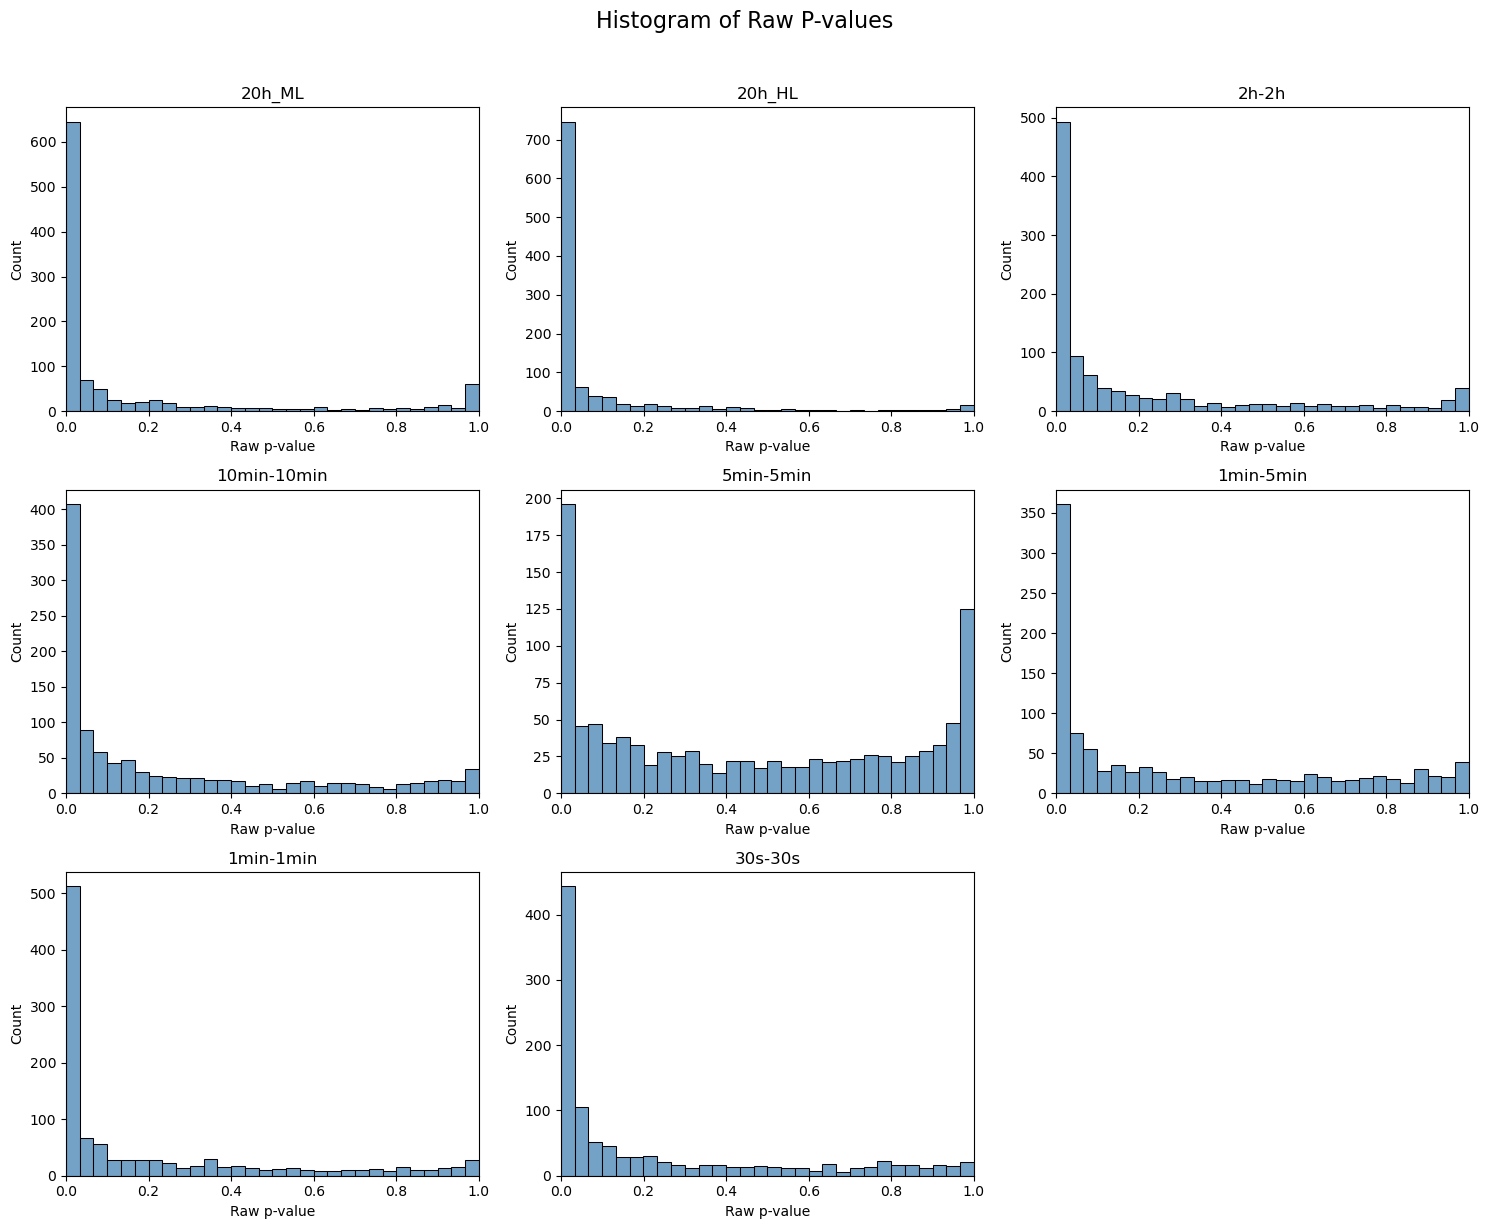

In [11]:
plot_pvalue_histograms_per_regime(epb_by_regime)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_1488/1452306677.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


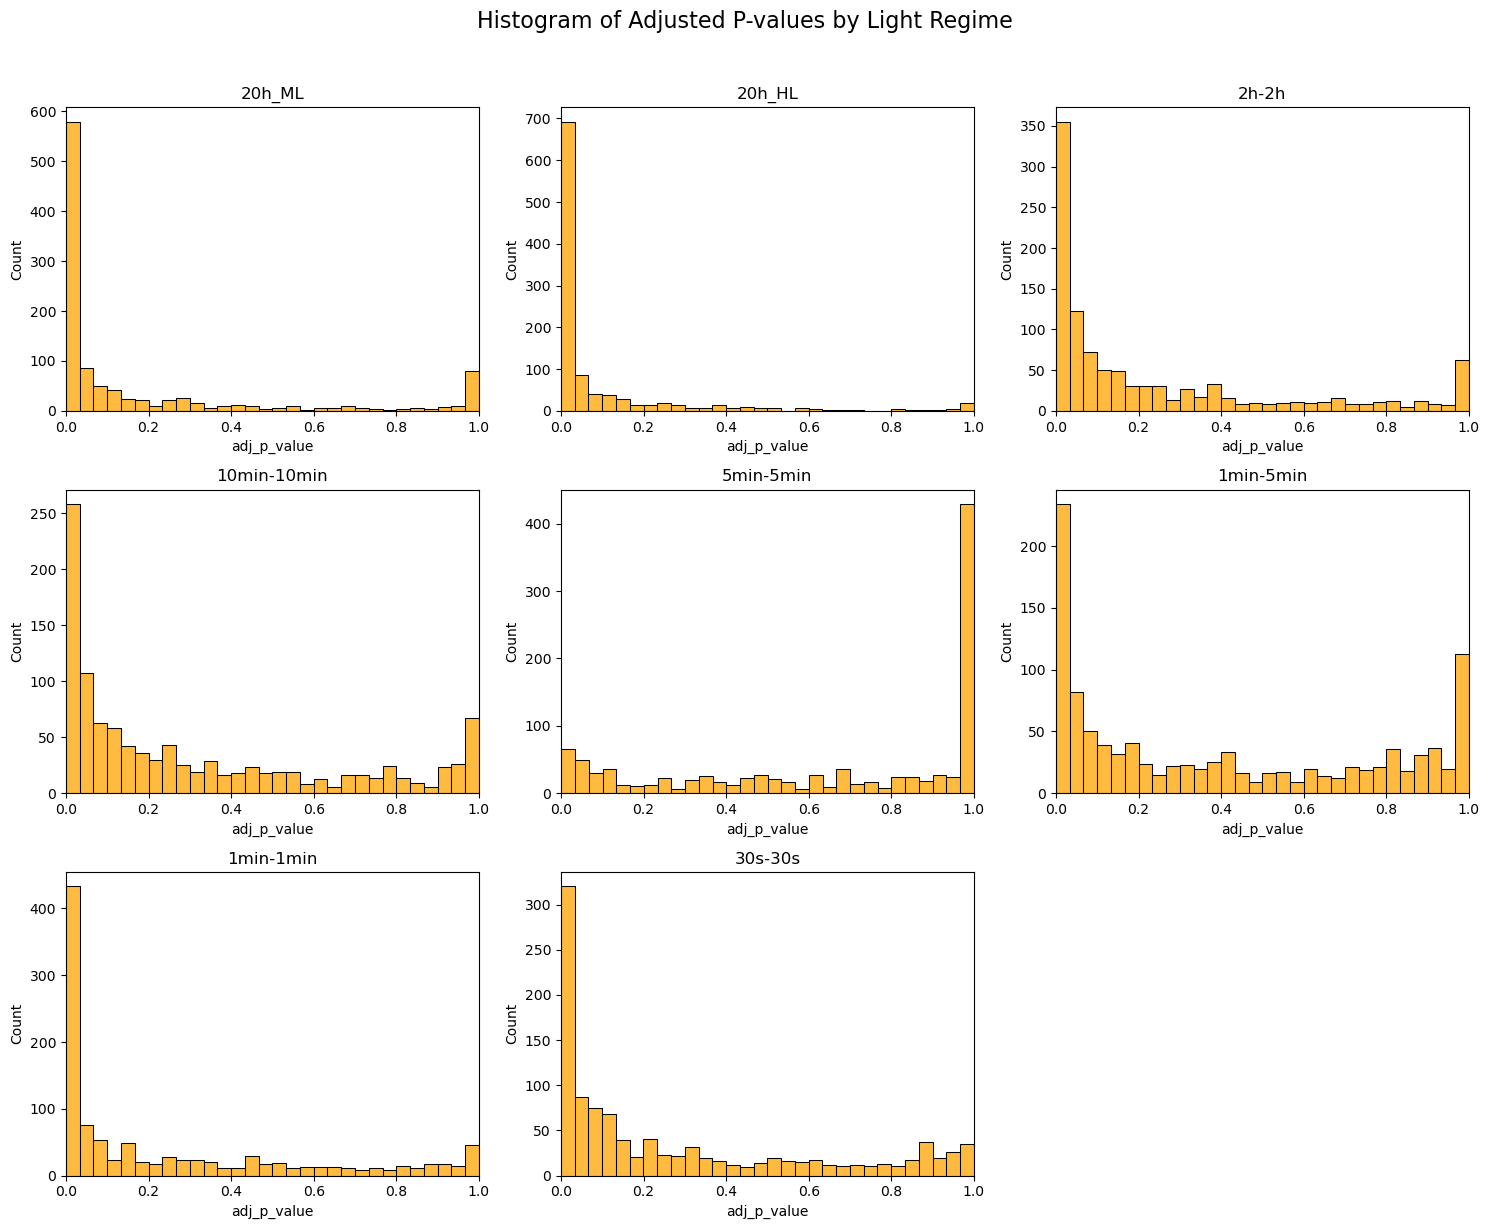

In [12]:
plot_BH_pvalue_histograms_per_regime(epb_by_regime)

In [13]:
from matplotlib import cm
def plot_volcano_per_light_regime1(ttest_results,
                                   p_thresh=1e-5,
                                   regimes_order=None,
                                   figsize=(14, 20),
                                   title_prefix='Volcano Plot'):
    
    # Compute effect size and -log10(p-adj)
    ttest_results['effect_size'] = ttest_results['delta_mean']
    ttest_results['neg_log10_p'] = -np.log10(ttest_results['p_adj'])

    # Define expected gene sets
    expected_ML =['Cre12.g531900']
    expected_2h =['Cre12.g531900']
    expected_10min =['Cre12.g531900']
    expected_5min =['Cre12.g531900']
    expected_1min_5min =['Cre12.g531900']
    expected_1min = {'Cre12.g531900', 'Cre16.g661200', 'Cre07.g314800', 'Cre13.g588150', 'Cre05.g235800','Cre15.g635800'}
    expected_30s = expected_1min
    expected_HL = {'Cre12.g531900','Cre02.g105350', 'Cre07.g323450'}

    # Combine all expected genes and assign unique colors
    all_expected_genes = sorted(set.union(expected_1min, expected_30s, expected_HL))
    expected_colors = sns.color_palette('Set1', n_colors=len(all_expected_genes))
    gene_to_color = dict(zip(all_expected_genes, expected_colors))

    # Determine plotting order
    if regimes_order is None:
        regimes = sorted(ttest_results['light_regime'].unique())
    else:
        regimes = regimes_order

    # Prepare subplot layout
    n = len(regimes)
    ncols = 2
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, regime in enumerate(regimes):
        ax = axes[i]
        df = ttest_results[ttest_results['light_regime'] == regime].copy()

        # Get expected genes per regime
        expected_set = (
            expected_1min if regime == '1min-1min' else
            expected_30s if regime == '30s-30s' else
            expected_HL if regime == '20h_HL' else
            expected_ML if regime == '20h_ML' else
            expected_5min if regime=='5min-5min' else
            expected_10min if regime=='10min-10min' else
            expected_1min_5min if regime=='1min-5min'else
            expected_2h if regime=='2h-2h'else
            set()
        )

        df_expected = df[df['mutated_genes'].isin(expected_set)]
        df_others = df[~df['mutated_genes'].isin(expected_set)]

        # Plot background genes
        ax.scatter(df_others['effect_size'], df_others['neg_log10_p'],
                   color='gray', alpha=0.5, label='_nolegend_')

        # Plot expected genes
        for gene in expected_set:
            gene_data = df_expected[df_expected['mutated_genes'] == gene]
            ax.scatter(gene_data['effect_size'], gene_data['neg_log10_p'],
                       color=gene_to_color[gene], label=gene, s=40, alpha=0.9)

        y_thresh_main = -np.log10(p_thresh)
        ax.axhline(y_thresh_main, color='blue', linestyle='--', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_main + 0.1,
            s=f'p = {p_thresh:.0e}',
            color='blue',
            ha='right',
            va='bottom',
            fontsize=10
        )
        
        
        # Threshold 3: p = 0.1
        y_thresh_01 = -np.log10(0.1)
        ax.axhline(y_thresh_01, color='green', linestyle='-.', linewidth=1)
        ax.text(
            x=0.95 * ax.get_xlim()[1],
            y=y_thresh_01 + 0.1,
            s='p = 0.1',
            color='green',
            ha='right',
            va='bottom',
            fontsize=10
        )

        # Set titles and labels
        ax.set_title(f'{title_prefix} — {regime}')
        ax.set_xlabel('Effect Size (Mutant - WT)')
        ax.set_ylabel('-log10(p-adjusted)')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add unified legend for expected genes
    legend_patches = [Patch(color=gene_to_color[gene], label=gene) for gene in all_expected_genes]
    fig.legend(handles=legend_patches, title='Expected Genes', bbox_to_anchor=(1.02, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout for side legend
    plt.show()

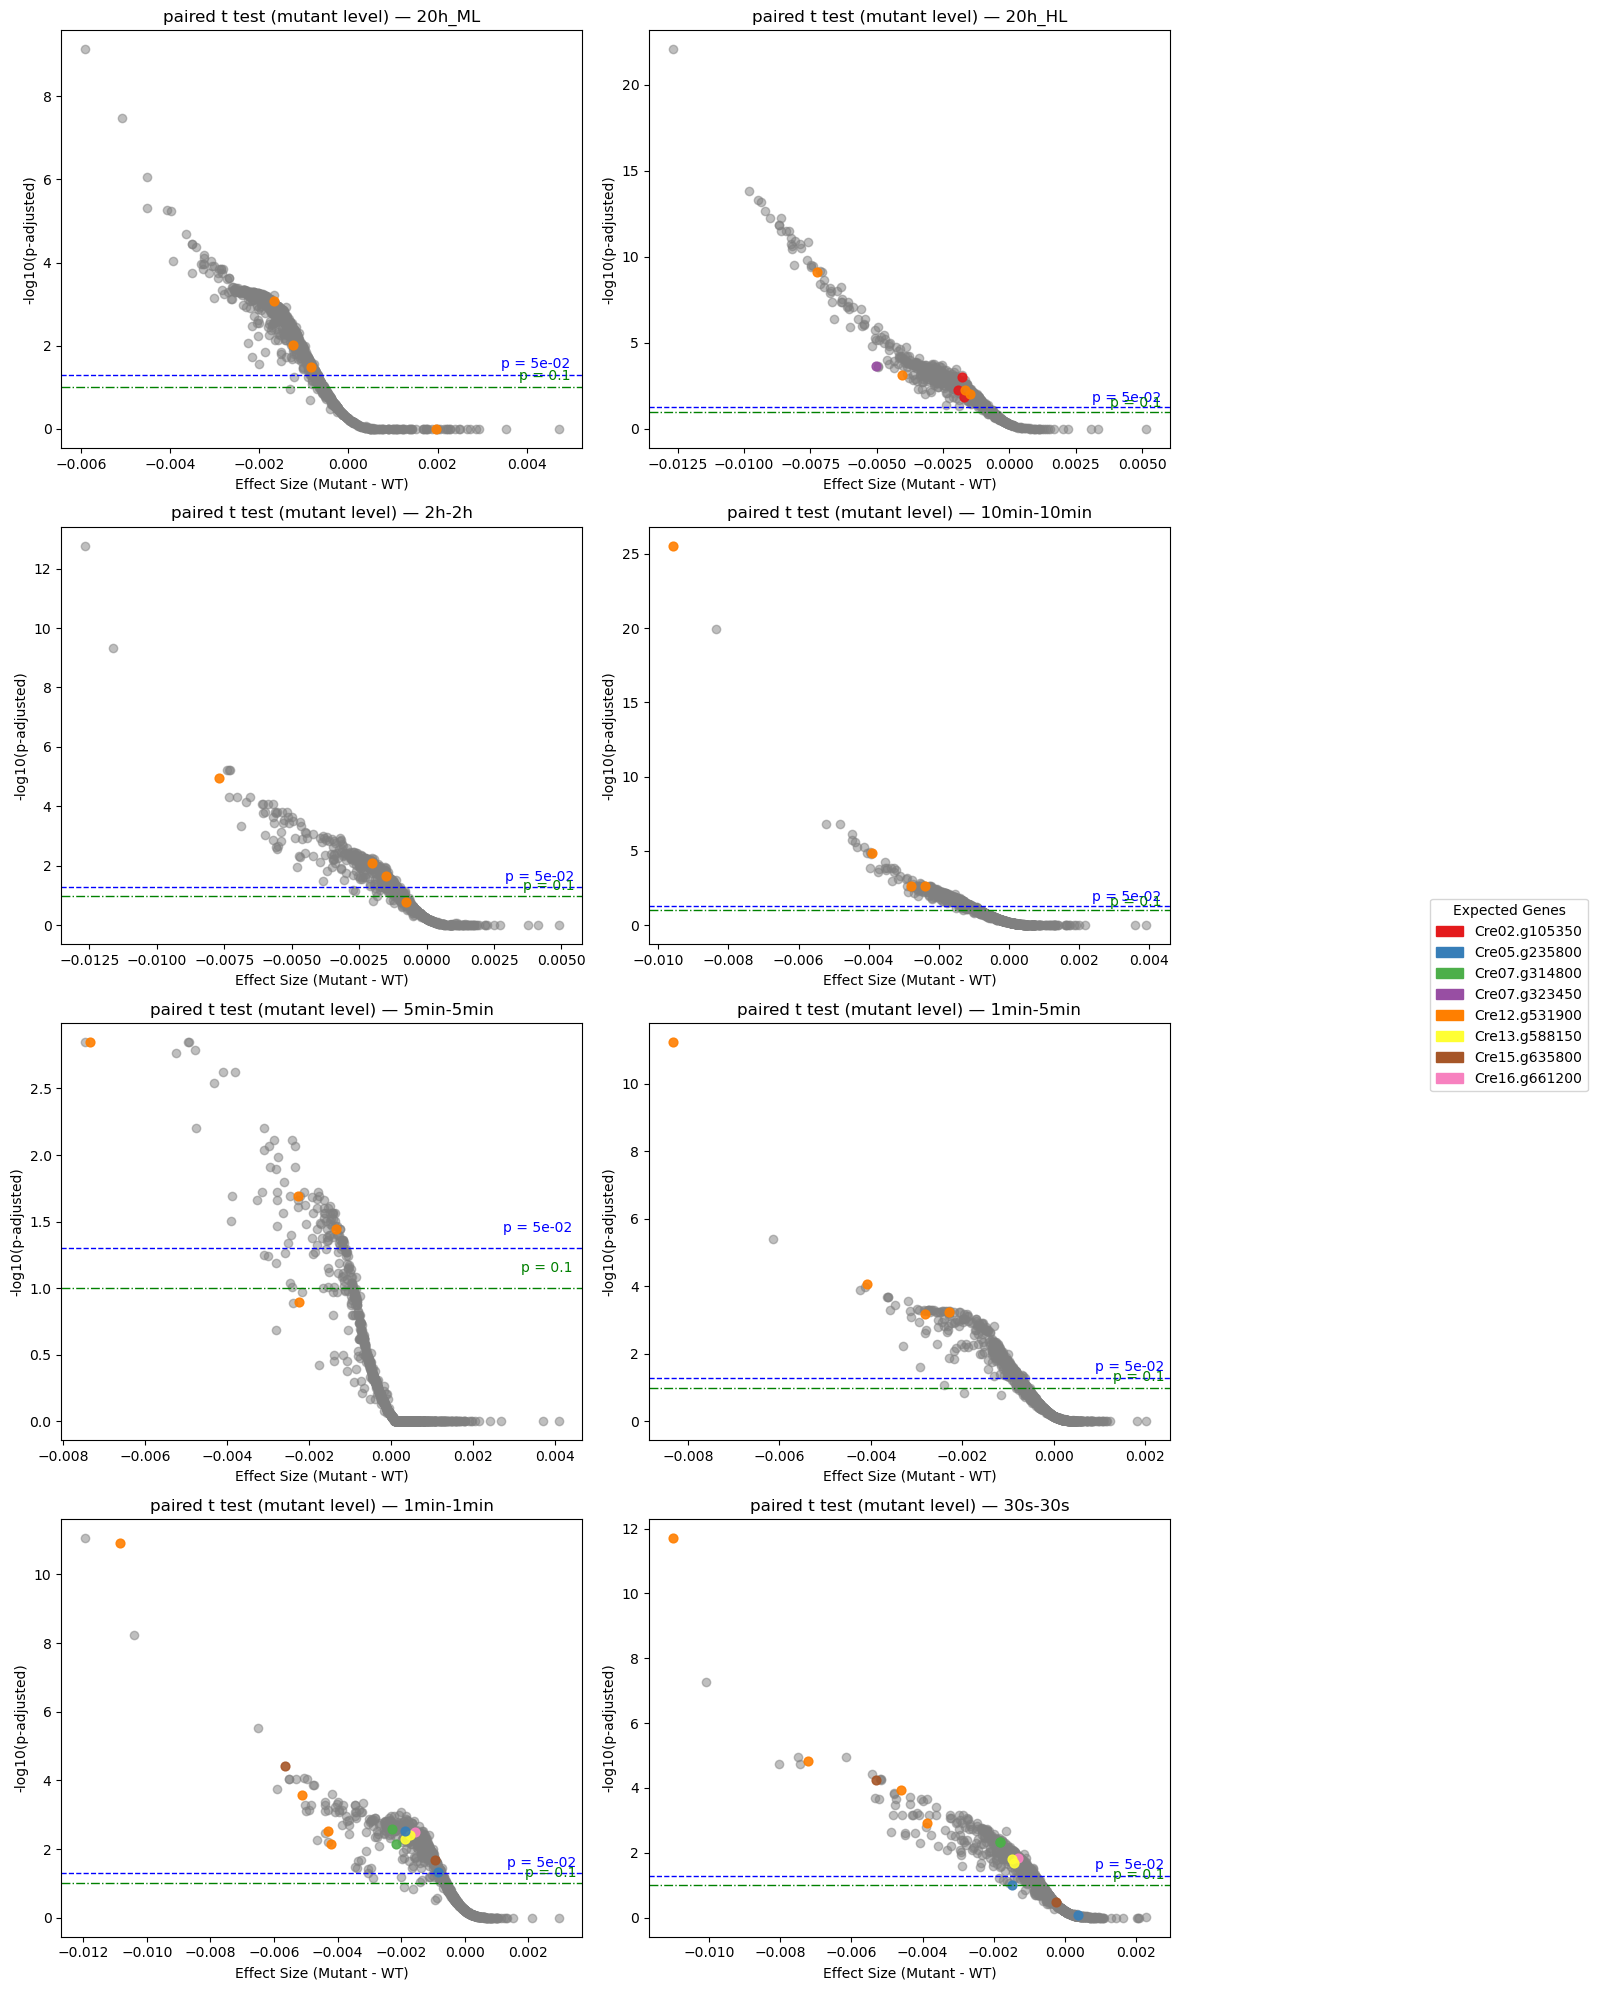

In [14]:
plot_volcano_per_light_regime1(
    epb_by_regime,
    p_thresh=0.05,
    regimes_order=['20h_ML','20h_HL','2h-2h','10min-10min','5min-5min','1min-5min', '1min-1min','30s-30s'],
    title_prefix='paired t test (mutant level)'
)

## paired t test (gene)

In [15]:
paired_gene_results = []

# group by gene and light regime
grouped = mutant_df.groupby(['mutated_genes', 'light_regime'])

for (gene, regime), group in grouped:
    # keep plate + value, drop missing
    group = group[['plate', 'y2_slope_select']].dropna()
    if group.empty:
        continue

    # for each plate, average all mutants of this gene (if multiple) -> one value per plate
    gene_plate_means = group.groupby('plate')['y2_slope_select'].mean()

    deltas = []
    for plate, gene_mean in gene_plate_means.items():
        # WT mean on the same plate & regime
        wt_vals = wt_df[
            (wt_df['light_regime'] == regime) &
            (wt_df['plate'] == plate)
        ]['y2_slope_select'].dropna()
        if wt_vals.empty:
            continue
        deltas.append(gene_mean - wt_vals.mean())

    # need at least 2 plates to estimate SEM
    if len(deltas) < 2:
        continue

    deltas = np.array(deltas, dtype=float)
    delta_mean = deltas.mean()
    se_hat = deltas.std(ddof=1) / np.sqrt(len(deltas))  # SEM of plate-level deltas

    paired_gene_results.append({
        'mutated_genes': gene,
        'light_regime': regime,
        'n_replicates': int(len(deltas)),   # number of plates used
        'delta_mean': float(delta_mean),
        'se_hat': float(se_hat)
    })

# DataFrame for R vash
paired_gene_df = pd.DataFrame(paired_gene_results)
paired_gene_df

,mutated_genes,light_regime,n_replicates,delta_mean,se_hat
0,Cre01.g000650,10min-10min,3,-0.001245,0.000246
1,Cre01.g000650,1min-1min,3,-0.002103,0.000667
2,Cre01.g000650,1min-5min,3,-0.000511,0.000479
3,Cre01.g000650,20h_HL,3,-0.003470,0.000444
4,Cre01.g000650,20h_ML,3,-0.001695,0.000094
...,...,...,...,...,...
4472,"unknown_chrom,Cre06.g302250",20h_HL,3,-0.003605,0.000531
4473,"unknown_chrom,Cre06.g302250",20h_ML,3,-0.000790,0.000481
4474,"unknown_chrom,Cre06.g302250",2h-2h,3,-0.000610,0.000313
4475,"unknown_chrom,Cre06.g302250",30s-30s,3,-0.002098,0.000273


In [16]:
# Prepare inputs for EPB
paired_gene_df = pd.DataFrame(paired_gene_results).copy()
paired_gene_df["df"] = paired_gene_df["n_replicates"] - 1
paired_gene_df["se_hat_sq"] = (paired_gene_df["se_hat"] ** 2)

# guard against zero/NaN SEs
paired_gene_df.loc[~np.isfinite(paired_gene_df["se_hat_sq"]) | (paired_gene_df["se_hat_sq"] <= 0), "se_hat_sq"] = 1e-12
paired_gene_df.loc[paired_gene_df["df"] < 1, "df"] = 1  


In [17]:
from statsmodels.stats.multitest import multipletests

rows = []

for regime, g in paired_gene_df.groupby("light_regime"):
    r = eb.epb_ttest(
        beta_hat=g["delta_mean"].to_numpy(),
        se_hat_squared=g["se_hat_sq"].to_numpy(),
        df=g["df"].to_numpy(),
        alpha=0.05,
    )

    g = g.copy()
    p_two = getattr(r, "pvalues", np.nan)

    # Convert to one-sided: H1: delta_mean < 0
    one_sided = np.where(
        g["delta_mean"] < 0,
        p_two / 2,
        1 - (p_two / 2)
    )

    g["p_value"] = one_sided

    # Apply BH correction to the one-sided p-values
    g["p_adj"] = multipletests(g["p_value"], method="fdr_bh")[1]

    # Keep all original columns + new p_value/p_adj
    g = g[["mutated_genes", "light_regime",
           "n_replicates", "delta_mean", "se_hat", "df",
           "se_hat_sq", "p_value", "p_adj"]]

    rows.append(g)

# Final concatenated DataFrame
epb_by_regime2 = pd.concat(rows, ignore_index=True)


 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   4.3597e-02  -1.5464e+02 | 1.42e+03  1.08e+02  1.40e+00 | 1.00e+00  1.00e+00  1.00e+00 |
    1  -2.2422e+00  -1.5973e+02 | 1.28e+03  1.10e+02  1.42e+00 | 8.83e-01  1.02e+00  9.00e-01 | 1.6e-12  3.5e-01  co-a  1.00e-01
    2  -5.2789e+00  -1.6420e+02 | 1.15e+03  1.11e+02  1.44e+00 | 7.87e-01  1.03e+00  8.10e-01 | 5.7e-13  2.4e-01  co-a  1.00e-01
    3  -9.1039e+00  -1.6869e+02 | 1.04e+03  1.12e+02  1.45e+00 | 7.05e-01  1.03e+00  7.29e-01 | 1.1e-12  6.1e-02  co-a  1.00e-01
    4  -2.9549e+01  -1.8839e+02 | 7.25e+02  1.12e+02  1.44e+00 | 4.94e-01  1.04e+00  5.10e-01 | 7.1e-13  6.5e-01  co-a  3.00e-01
    5  -8.0673e+01  -2.3895e+02 | 5.08e+02  1.12e+02  1.45e+00 | 3.45e-01  1.04e+00  3.58e-01 | 8.7e-13  5.0e-01  co-a  3.00e-01
    6  -1.8338e+02  -3.3968e+02 | 3.56e+02  1.12e+02  1.44e+00 | 2.42e-01  1.03e+00  2.51e-01 | 1.1e-12  3.2e-01  co-a  3.00e-01


/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_1488/3464260943.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


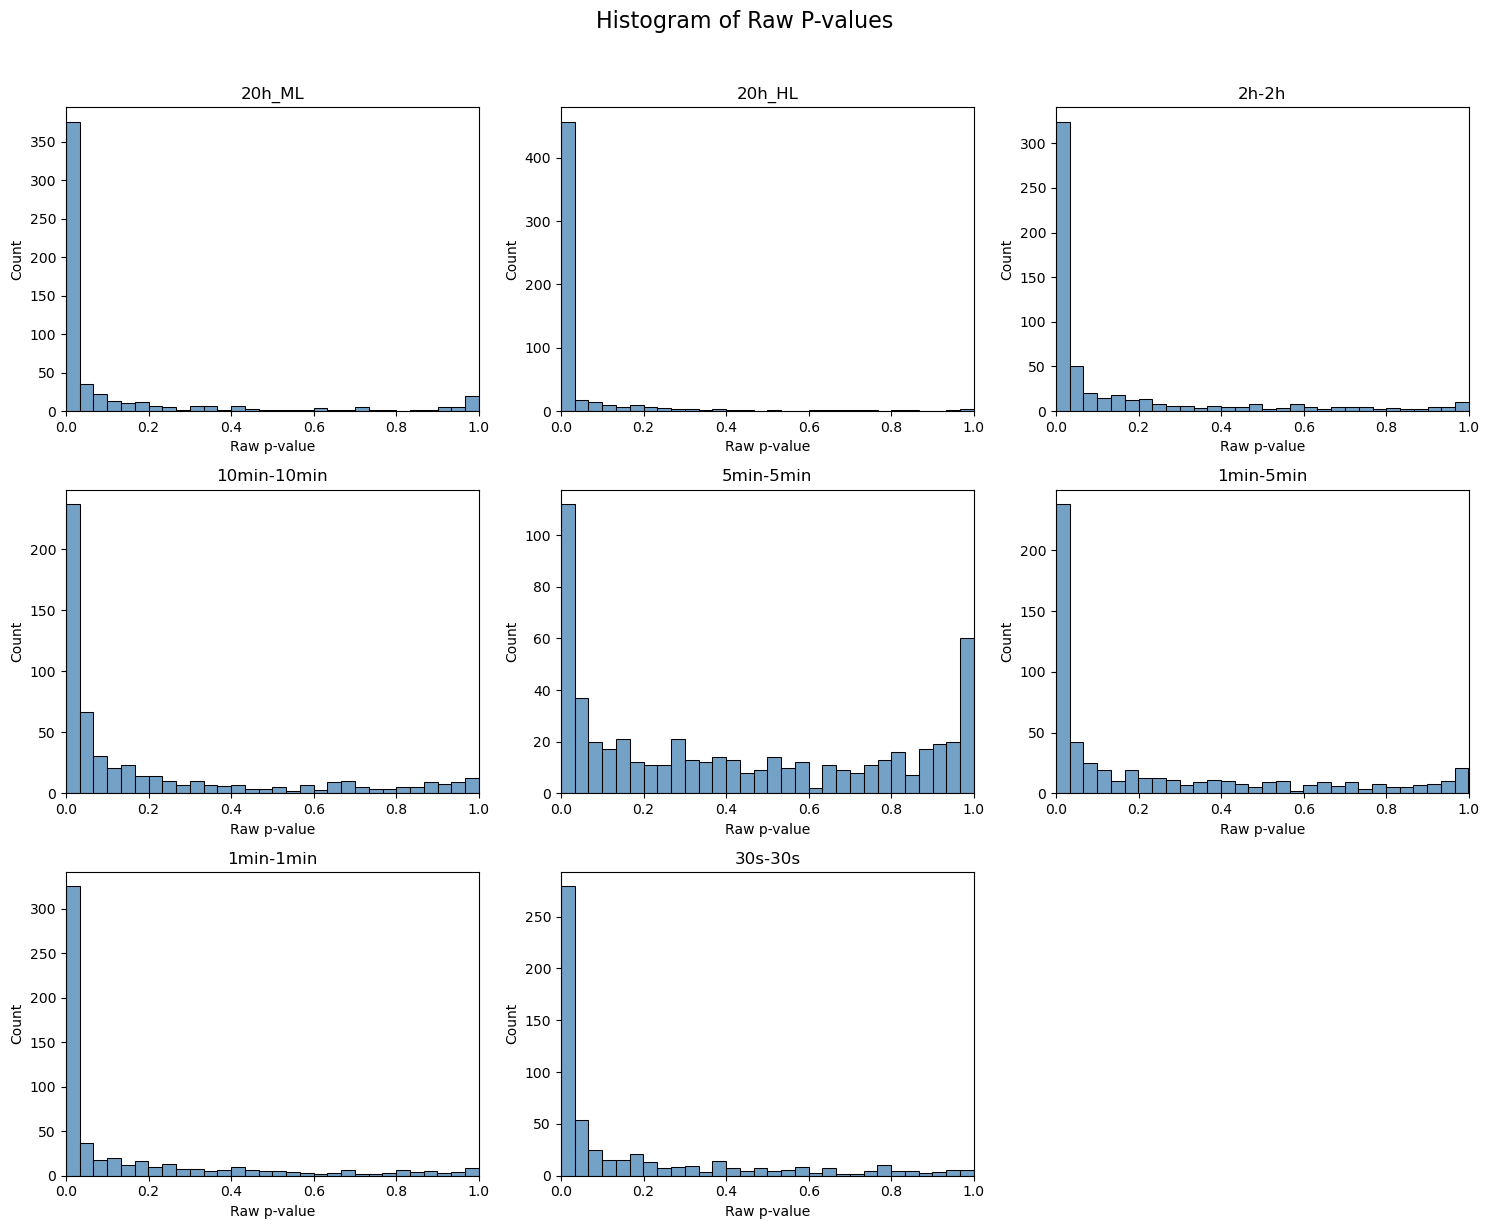

In [18]:
plot_pvalue_histograms_per_regime(epb_by_regime2)

/var/folders/t_/cq8kc3m112ndc44tfq9_3pgh0000gn/T/ipykernel_1488/1452306677.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


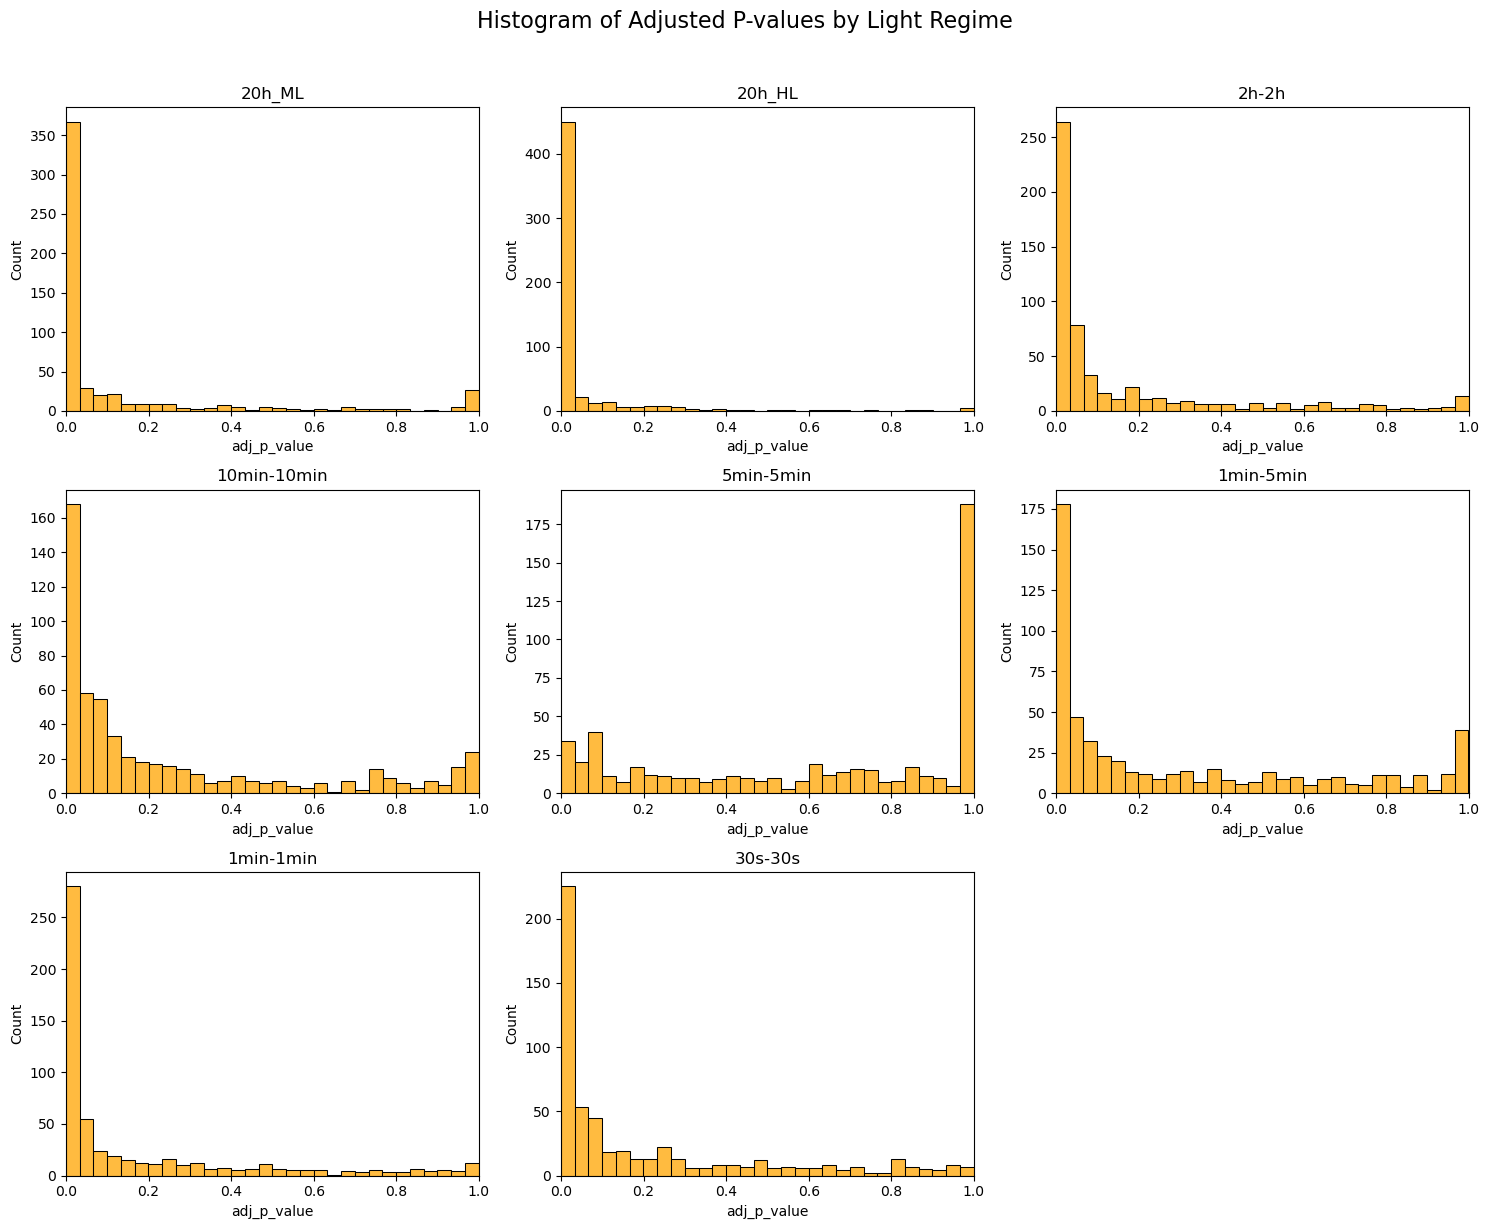

In [19]:
plot_BH_pvalue_histograms_per_regime(epb_by_regime2)

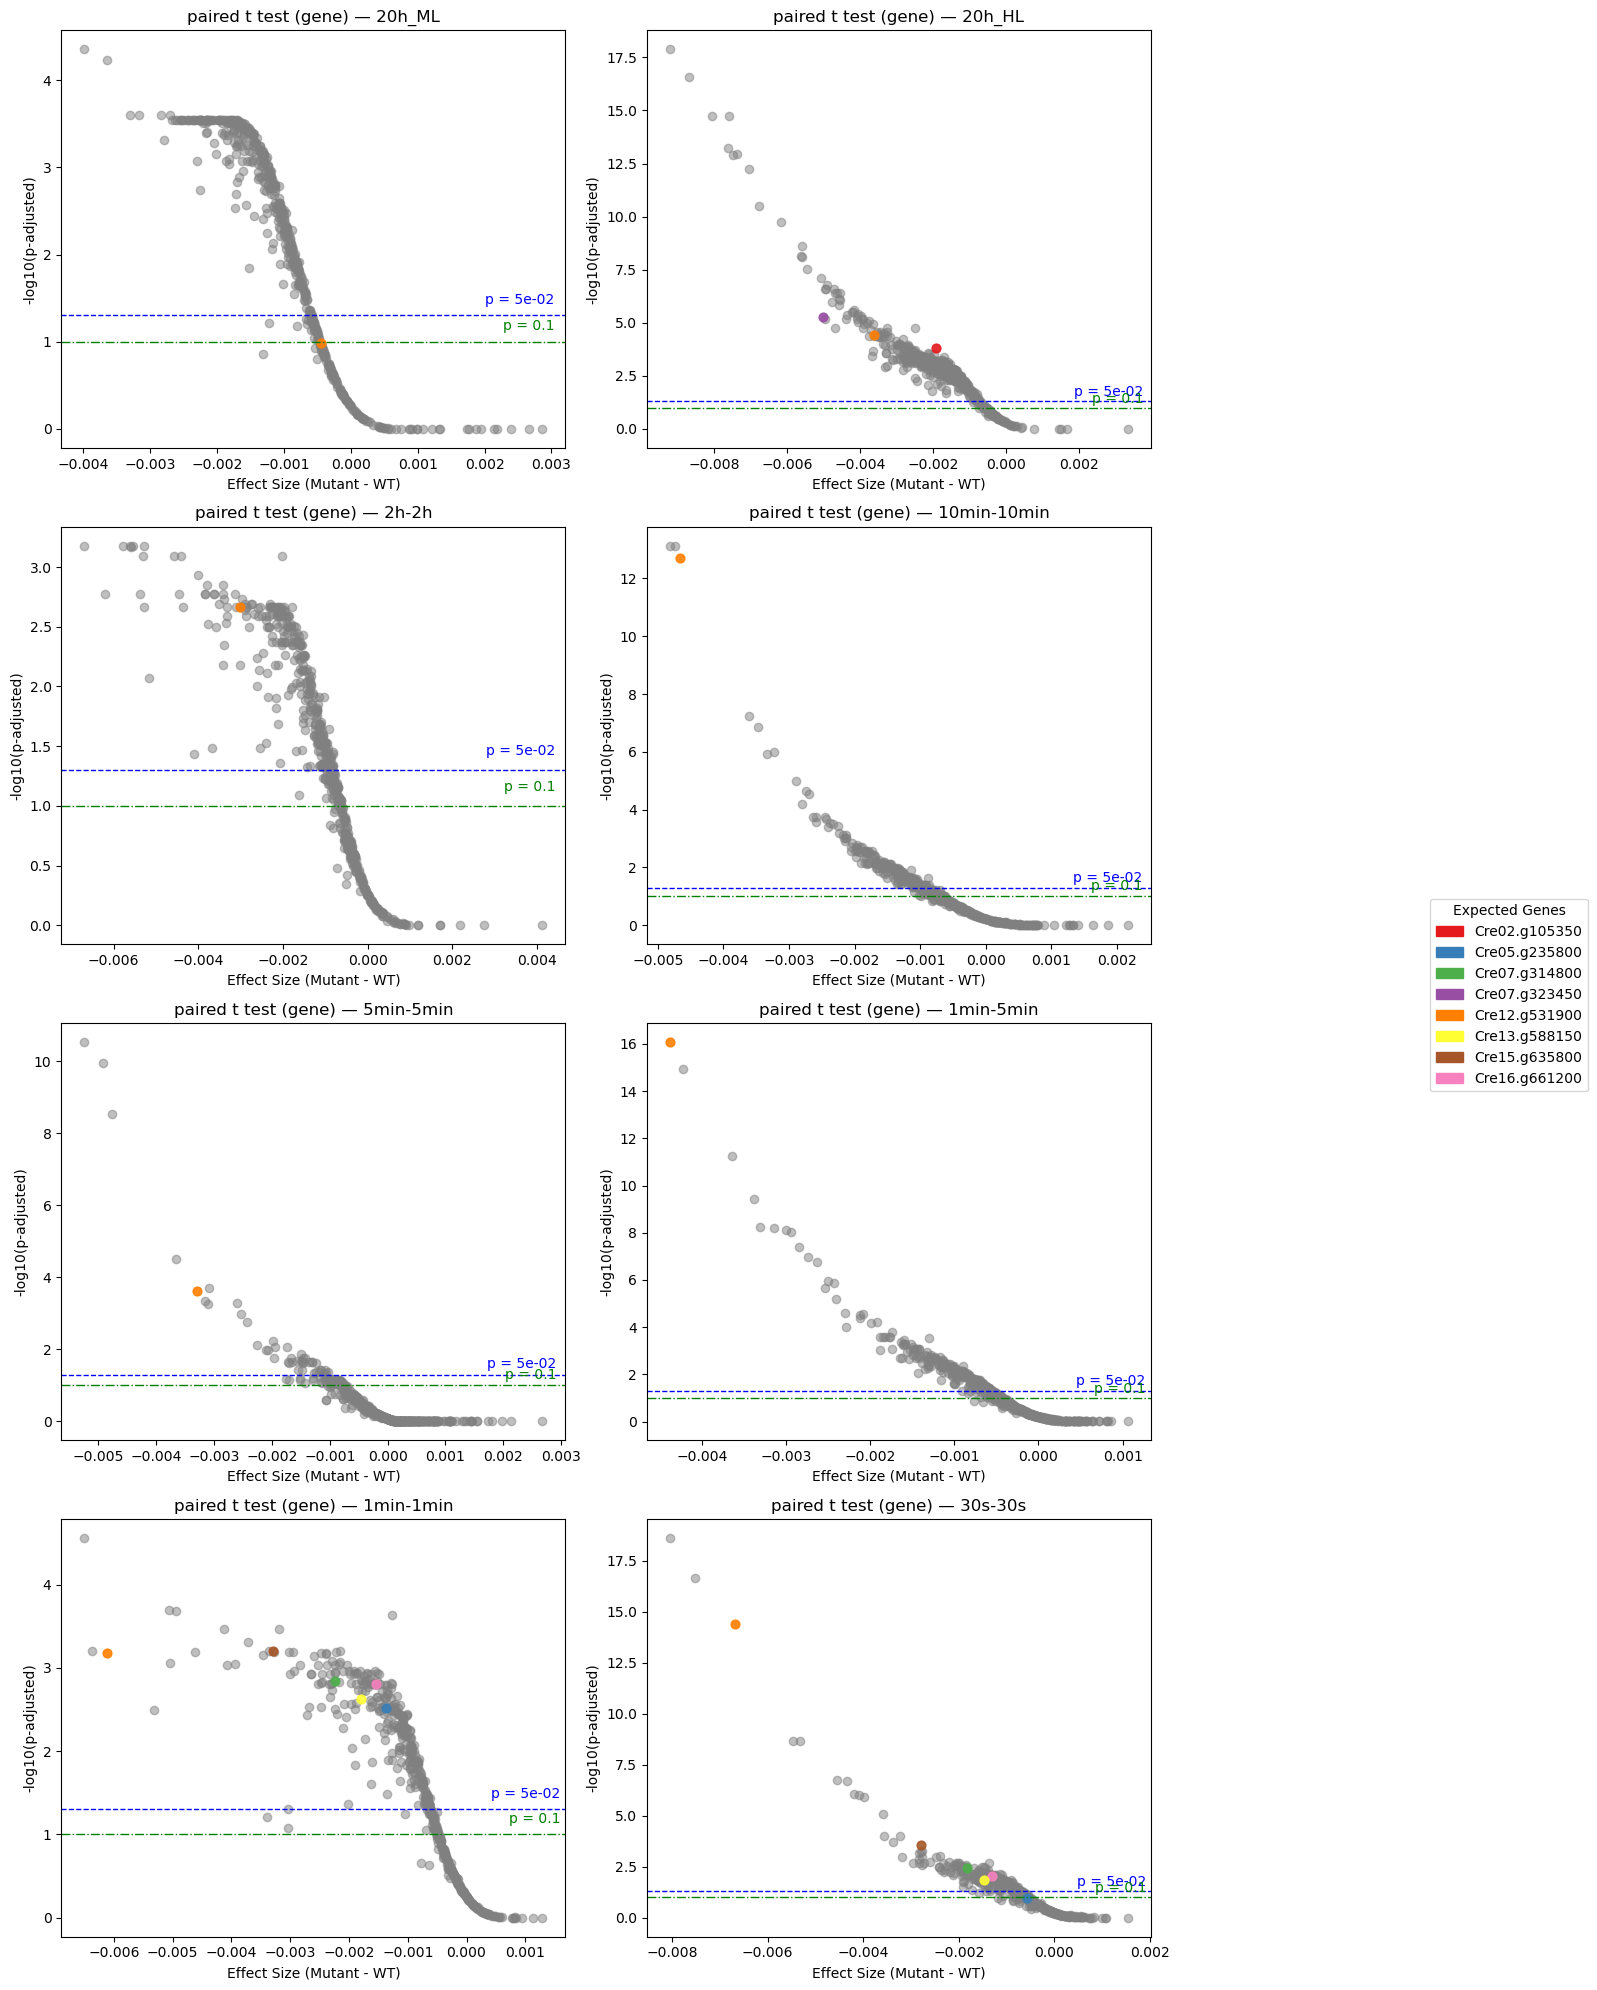

In [21]:
plot_volcano_per_light_regime1(
    epb_by_regime2,
    p_thresh=0.05,
    # regimes_order=['20h ML','20h HL','4h','20min','10min','1min-5min', '2min','1min'],
    regimes_order=['20h_ML','20h_HL','2h-2h','10min-10min','5min-5min','1min-5min', '1min-1min','30s-30s'],
    title_prefix='paired t test (gene)'
)